In [1]:
import sys
sys.path.append("../data/saved_models/")
sys.path.append("../model_scripts/")
sys.path.append("../utils/")
import os
import json

import numpy as np
import torch

import matplotlib.pyplot as plt
import fig2_plots

import fig2_analysis as rnn
import basic_analysis as basic
import model_utils
from task import generate_batch

In [2]:
# file paths
data_folder = f"../data/saved_models/1d_2map/"
save_folder = f"../figures/fig2_plots/"

if os.path.isdir(save_folder):
    print('save folder exists')
else:
    os.mkdir(save_folder)

save folder exists


In [3]:
# get the model IDs for all saved models
model_IDs = os.listdir(data_folder)

# select example model
ex_id = 0
model_ID = model_IDs[ex_id]

In [4]:
# get sample rnn data
model, task_params, _ = model_utils.load_model_params(data_folder, model_ID)
inputs, outputs, targets = model_utils.sample_rnn_data(data_folder, model_ID)
X, map_targ, pos_targ = model_utils.format_rnn_data(outputs["hidden_states"],\
                                                    targets["map_targets"],\
                                                    targets["pos_targets"])

In [5]:
# load the fixed points for the example model
vel_thresh = 0.005
fixed_pts, fixed_pts_torch, pos_pred_fp = rnn.load_fixed_pts(data_folder, model_ID,
                                                             vel_thresh=vel_thresh)

filtered out 12 slow points with velocity > threshold


In [6]:
# local linearization & eigendecomposition
Js, max_eigs, eig_vals, eig_vecs, sort_idx = rnn.characterize_fps(model,
                                                                  task_params,
                                                                  fixed_pts_torch)

100%|████████████████████████████████████████████████████| 988/988 [01:31<00:00,  8.69it/s]


In [7]:
pos_pred_fp = pos_pred_fp[sort_idx]
fixed_pts = fixed_pts[sort_idx]

In [8]:
# define saddle points as > 1 + tol and quasi-stable as 1 +/- tol
tol = 0.1

# saddle points
saddle_idx = max_eigs > 1+tol
n_saddle_pts = np.sum(saddle_idx)

# quasi-stable points
stable_idx = (max_eigs <= 1+tol) & (max_eigs >= 1-tol)
n_stable_pts = np.sum(stable_idx)

In [14]:
'''
choose 6 example points that are on the three rings 
these will be used for Figure 3A, B, D, 
'''
num_pts = fixed_pts.shape[0]

# number of example points for each ring
n_m1_ex = 2
n_m2_ex = 1
n_sd_ex = 3

# project the fixed points onto the context tuning dimension
X0 = X[map_targ==0]
X1 = X[map_targ==1]
fp_dist = rnn.dist_to_map(X0, X1, fixed_pts)

# index for fixed points on each map or in between
map_1_idx = np.round(fp_dist + 1, 1) == 0
map_2_idx = np.round(fp_dist - 1, 1) == 0
middle_idx = np.round(fp_dist, 1) == 0

# randomly choose points on each ring
ex_pts_m1 = np.random.choice(np.arange(num_pts)[stable_idx & map_1_idx],
                             size=n_m1_ex)
ex_pts_m2 = np.random.choice(np.arange(num_pts)[stable_idx & map_2_idx],
                             size=n_m2_ex)
ex_pts_saddle = np.random.choice(np.arange(num_pts)[saddle_idx & middle_idx],
                                 size=n_sd_ex)

ex_idx = np.concatenate([ex_pts_m1, ex_pts_m2, ex_pts_saddle]).astype(int)
not_ex_idx = np.setdiff1d(np.arange(num_pts), ex_idx)

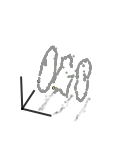

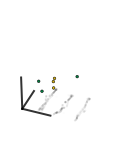

In [15]:
''' Figure 3A: fixed point rings with examples highlighted '''
f, ax = fig2_plots.plot_a(X, fixed_pts, pos_targ,
                          ex_idx, not_ex_idx)
ax.set_title('')
f.savefig(f'{save_folder}fixed_pts.png', dpi=1000, bbox_inches='tight')
plt.show()

f, ax = fig2_plots.plot_a(X, fixed_pts, pos_targ,
                         ex_idx, not_ex_idx, plot_all_pts=False)
ax.set_title('')
f.savefig(f'{save_folder}fixed_pts_ex_only.png', 
          transparent=True, dpi=1000, bbox_inches='tight')
plt.show()

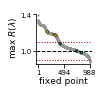

In [16]:
''' Figure 3B: largest eigenvalues for each fixed point '''
f, ax = fig2_plots.plot_b(max_eigs, ex_idx, tol)
plt.show()
# f.savefig(f'{save_folder}max_eigenvals.png', dpi=1000, bbox_inches='tight')

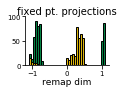

In [12]:
''' Figure 3C: projection of the fixed points onto the remapping dimension 
UPDATE TO SUMMARIZE ACROSS MODELS
'''
f, ax = fig2_plots.plot_c(fp_dist, stable_idx, saddle_idx)
plt.show()
f.savefig(f'{save_folder}fixed_pt_proj.png', dpi=1000, bbox_inches='tight')

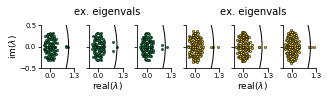

In [18]:
''' Figure 3D: eigenvalues for each example fixed point '''
f, gs = fig2_plots.plot_d(Js, ex_idx) 
plt.show()
f.savefig(f'{save_folder}ex_eigenvals.png', dpi=1000, bbox_inches='tight')